# Import Necessary Libraries

1. **NumPy (`import numpy as np`) and JAX (`import jax`)**:
   - NumPy is a popular library for numerical computations in Python.
   - JAX is a library for numerical computing that provides a NumPy-like interface but is designed for high-performance numerical operations, particularly on GPUs and TPUs.

2. **JAX NumPy (`import jax.numpy as jnp`)**:
   - JAX provides its own version of NumPy functions and arrays. It's used for numerical computations and can take advantage of hardware accelerators for better performance.

3. **tqdm (`import tqdm`)**:
   - tqdm is a library for adding progress bars to your loops or tasks. It helps you visualize the progress of your code.

4. **Matplotlib (`import matplotlib.pyplot as plt`)**:
   - Matplotlib is a widely-used library for creating static, animated, or interactive visualizations in Python. In this code, it's likely used for plotting and visualizing data.

5. **esda (`import esda`)**:
   - esda stands for Exploratory Spatial Data Analysis. It's a part of PySAL (Python Spatial Analysis Library) and is used for analyzing spatial data.

6. **libpysal (`import libpysal`)**:
   - libpysal is another library for spatial analysis in Python. It provides tools for working with spatial data and conducting various spatial analyses.

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import tqdm
import matplotlib.pyplot as plt

import esda
import libpysal
import os

# Helping Functions

In [3]:
def box_plot(data, base_folder=''):
    fig, ax = plt.subplots()
    ax.boxplot(data)
    ax.set_xticklabels(['Data_'+str(i) for i in range(len(data))])
    ax.set_ylabel('PSNR values')
    ax.set_title("Moran's I complexity")
    plt.savefig(base_folder+'Analysis_compexity_vs_psnr.png')
    plt.show()

# File Operation:-

In [4]:
def append_array_to_csv(filename, array):
    try:
        with open(filename, 'w') as file:
            np.savetxt(file, array, delimiter=',', fmt='%s')
            print("Array appended to CSV successfully.")
    except Exception as e:
        print("Error:", e)


def read_csv_to_array(filename):
    try:
        data_array = np.loadtxt(filename, delimiter=',')
        return data_array
    except Exception as e:
        print("Error:", e)
        return None


def load_jax_array(file_path):
    with open(file_path, 'rb') as f:
        loaded_array = jnp.load(f)
    return loaded_array


def save_jax_array_as_jax(jax_array, file_path):
    with open(file_path, 'wb') as f:
        jnp.save(f, jax_array)

# Predefined Variables

In [5]:
NUM_MAP_SAMPLES = 500
MAP_SIZE = [10, 10]
NUM_DIPOLE_SAMPLES = 50
NUM_DIPOLES_PER_SAMPLE = 200
SPARSITY = 0.5
MU, SIGMA = 0, 0.01
TYPE = 'Gaussian'
BASE_SAVE_FOLDER = f'Datasets{NUM_MAP_SAMPLES,MAP_SIZE,NUM_DIPOLE_SAMPLES,NUM_DIPOLES_PER_SAMPLE,SPARSITY,MU,SIGMA}/'
os.makedirs(BASE_SAVE_FOLDER,exist_ok=True)
os.makedirs(BASE_SAVE_FOLDER+'Gaussian_A_vectors/',exist_ok=True)
os.makedirs(BASE_SAVE_FOLDER+'Uniform_A_vectors/',exist_ok=True)
os.makedirs(BASE_SAVE_FOLDER+'Gaussian_B_vectors/',exist_ok=True)
os.makedirs(BASE_SAVE_FOLDER+'Uniform_B_vectors/',exist_ok=True)
os.makedirs(BASE_SAVE_FOLDER+'Maps/',exist_ok=True)
# os.mkdirs(BASE_SAVE_FOLDER+'/'+'',exist_ok=True)

# Generating Classes of Map and Dipoles

In [6]:
key = jax.random.PRNGKey(0)


def bresenham_line(x1, y1, x2, y2):
    line_points = []
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    step_x = 1 if x1 < x2 else -1
    step_y = 1 if y1 < y2 else -1
    error = dx - dy

    while True:
        line_points.append((x1, y1))
        if x1 == x2 and y1 == y2:
            break
        double_error = 2 * error
        if double_error > -dy:
            error -= dy
            x1 += step_x
        if double_error < dx:
            error += dx
            y1 += step_y

    return line_points


class GenerateMap:
    def __init__(self) -> None:
        pass

    def generate_map(self, sparsity=SPARSITY, samples=NUM_MAP_SAMPLES):
        random_numbers = jax.random.uniform(key, shape=(samples, *MAP_SIZE))
        sparse_maps = jnp.where(random_numbers <= sparsity, 0, 1)
        return sparse_maps


class GenerateDipole:
    def __init__(self) -> None:
        pass

    def uniform_generate(self):
        sender_xy_points = jax.random.randint(key, shape=(
            NUM_DIPOLE_SAMPLES, NUM_DIPOLES_PER_SAMPLE, 2), minval=0, maxval=MAP_SIZE[0])
        reciever_xy_points = jax.random.randint(key, shape=(
            NUM_DIPOLE_SAMPLES, NUM_DIPOLES_PER_SAMPLE, 2), minval=0, maxval=MAP_SIZE[0])
        return sender_xy_points, reciever_xy_points

    def gaussian_generate(self, mu=[5, 5], std=[15, 15], samples=NUM_DIPOLE_SAMPLES, per_sample=NUM_DIPOLES_PER_SAMPLE):
        keys = jax.random.split(key, 2)
        sender_x_points = std[0] * \
            jax.random.normal(keys[0], shape=(samples, per_sample)) + mu[0]
        sender_y_points = std[1] * \
            jax.random.normal(keys[0], shape=(samples, per_sample)) + mu[1]
        sender_xy_points = jnp.stack([sender_x_points, sender_y_points]).reshape(
            (samples, per_sample, 2)).astype(jnp.int32)
        sender_xy_points = jnp.clip(
            sender_xy_points, a_min=0, a_max=MAP_SIZE[0])

        receiver_x_points = std[0] * \
            jax.random.normal(keys[1], shape=(samples, per_sample)) + mu[0]
        receiver_y_points = std[1] * \
            jax.random.normal(keys[1], shape=(samples, per_sample)) + mu[1]
        receiver_xy_points = jnp.stack([receiver_x_points, receiver_y_points]).reshape(
            (samples, per_sample, 2)).astype(jnp.int32)
        receiver_xy_points = jnp.clip(
            receiver_xy_points, a_min=0, a_max=MAP_SIZE[0])
        return sender_xy_points, receiver_xy_points


class Map:
    def __init__(self, attenuation_map):
        self.attenuation_map = attenuation_map
        noise = SIGMA*jax.random.normal(key, shape=MAP_SIZE)+MU
        self.attenuation_map = jnp.array(self.attenuation_map)+noise
        self.shape = self.attenuation_map.shape

    def find_cut_indices(self, matrix, x1, y1, x2, y2):
        cut_indices = []
        line_points = bresenham_line(x1, y1, x2, y2)

        for x, y in line_points:
            if 0 <= x < len(matrix) and 0 <= y < len(matrix[0]):
                cut_indices.append((x, y))
        return cut_indices

    def attenuation_result(self, transmitter, reflector):
        cuts = self.find_cut_indices(
            self.attenuation_map, *transmitter, *reflector)
        mask = np.zeros(self.attenuation_map.shape)
        for i in cuts:
            mask[i[0]][i[1]] = 1

        A_vector = mask.astype(np.float32)
        B_vector = np.dot(A_vector.reshape(-1),
                          self.attenuation_map.reshape(-1, 1))
        return A_vector, B_vector

    def generate_A_B(self, sender_dipoles, receiver_dipoles):
        A_samples_list = []
        B_samples_list = []

        for transmitter, receiver in zip(sender_dipoles, receiver_dipoles):
            A, B = self.attenuation_result(transmitter, receiver)
            A_samples_list.append(A)
            B_samples_list.append(B)

        A_samples = jnp.array(A_samples_list, dtype=jnp.float32).reshape(
            NUM_DIPOLES_PER_SAMPLE, -1)
        B_samples = jnp.array(B_samples_list, dtype=jnp.float32).reshape(
            NUM_DIPOLES_PER_SAMPLE, -1)

        return jnp.array(A_samples), jnp.array(B_samples)

# Dataset Preparation Class

In [7]:
class Dataset(GenerateMap, GenerateDipole):
    def __init__(self) -> None:
        self.map_gen = GenerateMap()
        self.dipole_gen = GenerateDipole()

    def initialize_dataset(self,type = 'Gaussian') -> None:
        self.maps = self.map_gen.generate_map()
        if type == 'Gaussian':
            sender, receiver = self.dipole_gen.gaussian_generate()
        elif type == 'Uniform':
            sender, receiver = self.dipole_gen.uniform_generate()
        else:
            print('Wrong Inputs')
            return
        
        for indx, map_item in tqdm.tqdm(enumerate(self.maps)):
            if indx < 408:
                continue
            map_made = Map(map_item)
            A_coll, B_coll = [], []
            for indy, (send, rec) in enumerate(zip(sender, receiver)):
                A, B = map_made.generate_A_B(send, rec)
                A_coll.append(A)
                B_coll.append(B)
            A_coll = jnp.array(A_coll)
            B_coll = jnp.array(B_coll)

            save_jax_array_as_jax(
                map_item, file_path=BASE_SAVE_FOLDER+'Maps/Map{}_{}.bin'.format(indx, *MAP_SIZE))
            save_jax_array_as_jax(A_coll, file_path=BASE_SAVE_FOLDER+type+'_A_vectors/'+'A_{}_{}_{}.bin'.format(
                indx, indy, [NUM_DIPOLE_SAMPLES, NUM_DIPOLES_PER_SAMPLE, MAP_SIZE]))
            save_jax_array_as_jax(B_coll, file_path=BASE_SAVE_FOLDER+type+'_B_vectors/'+'B_{}_{}_{}.bin'.format(
                indx, indy, [NUM_DIPOLE_SAMPLES, NUM_DIPOLES_PER_SAMPLE, 1]))

# Save File to variable loading

In [8]:
def collect_data_from_dataset(loc=BASE_SAVE_FOLDER,type=TYPE):
    maps, A_vectors, B_vectors = [], [], []
    for i in range(NUM_MAP_SAMPLES):
        maps.append(load_jax_array(
            loc+'Maps/Map{}_{}.bin'.format(i, *MAP_SIZE)))
        A_vectors.append(load_jax_array(loc+type+'_A_vectors/'+'A_{}_{}_{}.bin'.format(
            i, NUM_DIPOLE_SAMPLES-1, [NUM_DIPOLE_SAMPLES, NUM_DIPOLES_PER_SAMPLE, MAP_SIZE])))
        B_vectors.append(load_jax_array(loc+type+'_B_vectors/'+'B_{}_{}_{}.bin'.format(
            i, NUM_DIPOLE_SAMPLES-1, [NUM_DIPOLE_SAMPLES, NUM_DIPOLES_PER_SAMPLE, 1])))

    maps = jnp.array(maps)
    A_vectors = jnp.array(A_vectors)
    B_vectors = jnp.array(B_vectors)
    return maps, A_vectors, B_vectors


# Creation Of Dataset

In [9]:
# obj = Dataset()
# obj.initialize_dataset(type='Uniform')

# obj = Dataset()
# obj.initialize_dataset()

# Saved dataset Loading 

In [10]:
def morans_i(data):
    w = libpysal.weights.lat2W(data.shape[0], data.shape[1])
    mi = esda.moran.Moran(data, w)
    return mi.I


maps, A_vectors, B_vectors = collect_data_from_dataset()
values = jnp.array([morans_i(map) for map in maps])

# Analysis with Moran's I complexity sorting with min to max

In [11]:
@jax.jit
def sort_with_key(arr, key):
    sorted_indices = jnp.argsort(key)
    sorted_arr = arr[sorted_indices]
    sorted_key = key[sorted_indices]
    return sorted_arr, sorted_key

maps, A_vectors, B_vectors = collect_data_from_dataset()
values = jnp.array([morans_i(map) for map in maps])

maps, keys = sort_with_key(maps, key=values)
A_vectors,keys = sort_with_key(A_vectors, key=values)
B_vectors,keys = sort_with_key(B_vectors,key=values)

temp_A_vec = A_vectors.reshape(-1,NUM_DIPOLES_PER_SAMPLE,MAP_SIZE[0]*MAP_SIZE[1])
temp_B_vec = B_vectors.reshape(-1,NUM_DIPOLES_PER_SAMPLE,1)

@jax.jit
def scale(data):
    minm = jnp.min(data,axis = 0)
    maxm = jnp.max(data,axis = 0)
    return (data - minm)/(maxm-minm)

# temp_A_vec = scale(temp_A_vec)
    

# visualizing the maps

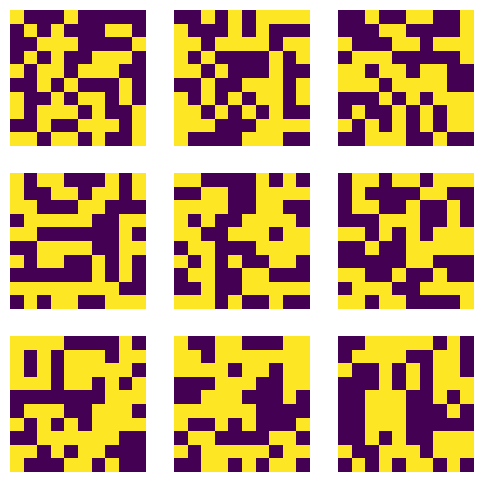

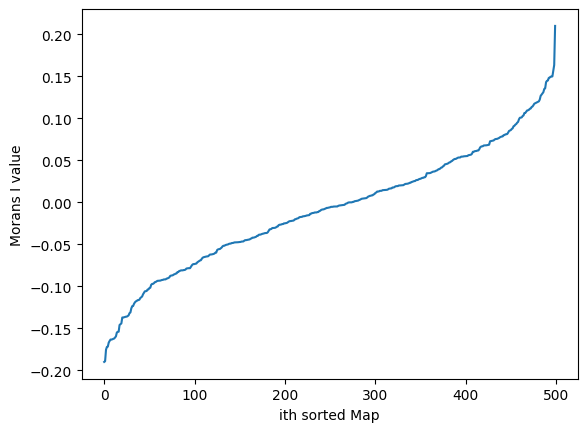

In [12]:
# import matplotlib.pyplot as plt
# import numpy as np

# Generate 9 random 2D images (example data)
images = [maps[int((i/9)*len(maps))] for i in range(9)]

# Create a 3x3 grid of images
fig, axs = plt.subplots(3, 3, figsize=(6, 6))

# Loop through the images and plot them in the grid
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(images[i * 3 + j])  # Assuming grayscale images
        axs[i, j].axis('off')  # Turn off axis for clarity
plt.savefig(BASE_SAVE_FOLDER +
            f'SAMPLES_{MAP_SIZE,NUM_DIPOLE_SAMPLES,NUM_DIPOLES_PER_SAMPLE}.png')
plt.show()  # Display the grid of images

plt.plot(sorted(values))  # morans_i
plt.xlabel('ith sorted Map')
plt.ylabel('Morans I value')
plt.savefig(BASE_SAVE_FOLDER +
            f'MORANSI_{MAP_SIZE,NUM_DIPOLE_SAMPLES,NUM_DIPOLES_PER_SAMPLE}.png')
plt.show()

# Regenerate Maps

In [ ]:
@jax.jit
def solver(A, B):
    term1 = jnp.linalg.pinv(jnp.dot(A.T, A))
    term2 = jnp.dot(A.T, B)
    X = jnp.dot(term1, term2)
    return X

resolved = []
for A,B in tqdm.tqdm(zip(temp_A_vec,temp_B_vec)):
    resolved.append(solver(A,B).reshape(MAP_SIZE))
resolved = jnp.array(resolved).reshape(NUM_MAP_SAMPLES,NUM_DIPOLE_SAMPLES,*MAP_SIZE)
print(resolved.shape) 

25000it [01:31, 274.31it/s]


(500, 50, 10, 10)


# Visualization of Results

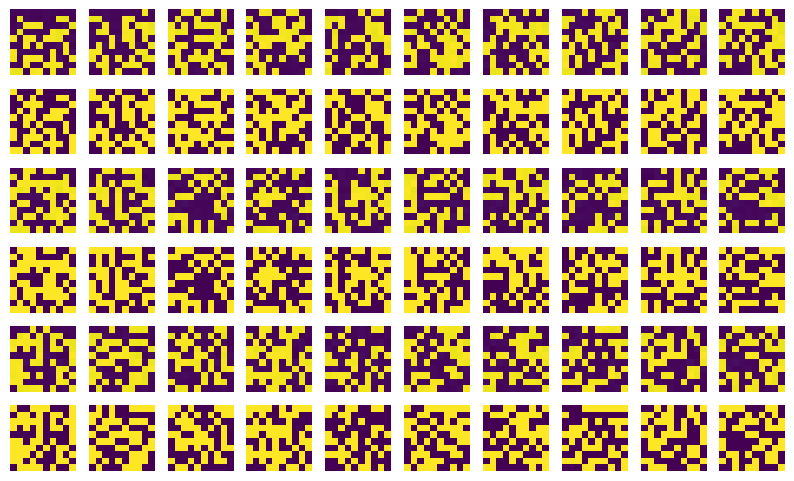

In [ ]:
# Generate 9 random 2D images (example data)
reformed = resolved[:,0,:,:]
original = maps
M,N = 3,10
reformed_subset = np.array([reformed[i] for i in range(M*N)])
original_subset = np.array([original[i] for i in range(M*N)])


fig, axs = plt.subplots(2*M, N, figsize=(N, 2*M))

for i in range(M):
    for j in range(N):
        axs[2*i, j].imshow(original_subset[i * N + j]) 
        axs[2*i, j].axis('off') 
        axs[2*i+1, j].imshow(reformed_subset[i * N + j],cmap = 'virdis')  
        axs[2*i+1, j].axis('off') 
plt.savefig(BASE_SAVE_FOLDER +
            f'SAMPLES_results_{MAP_SIZE,NUM_DIPOLE_SAMPLES,NUM_DIPOLES_PER_SAMPLE}.png')
plt.show()  

# Calculation of PSNR Values and storage

In [ ]:
@jax.jit
def psnr(img1, img2):
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions")
    mse = jnp.mean((img1 - img2) ** 2)
    dynamic_range = jnp.max(img1) - jnp.min(img1)
    psnr_value = 20 * jnp.log10(dynamic_range) - 10 * jnp.log10(mse)
    return psnr_value


@jax.jit
def mse(img1, img2):
    return jnp.mean(jnp.square(img1-img2))


psnr_values = []
for i in tqdm.tqdm(range(NUM_MAP_SAMPLES)):
    temp_array = []
    for j in range(NUM_DIPOLE_SAMPLES):
        temp_array.append(psnr(maps[i], resolved[i][j]))
    psnr_values.append(temp_array)

psnr_values = np.array(psnr_values)
append_array_to_csv(
    BASE_SAVE_FOLDER+f'output_{MAP_SIZE,NUM_DIPOLE_SAMPLES,NUM_DIPOLES_PER_SAMPLE,TYPE}.csv', psnr_values)

100%|██████████| 500/500 [01:51<00:00,  4.47it/s]


Array appended to CSV successfully.


# Plotting of PSNR values for each Dipole sample max mean and min value with increasing map complexity:-

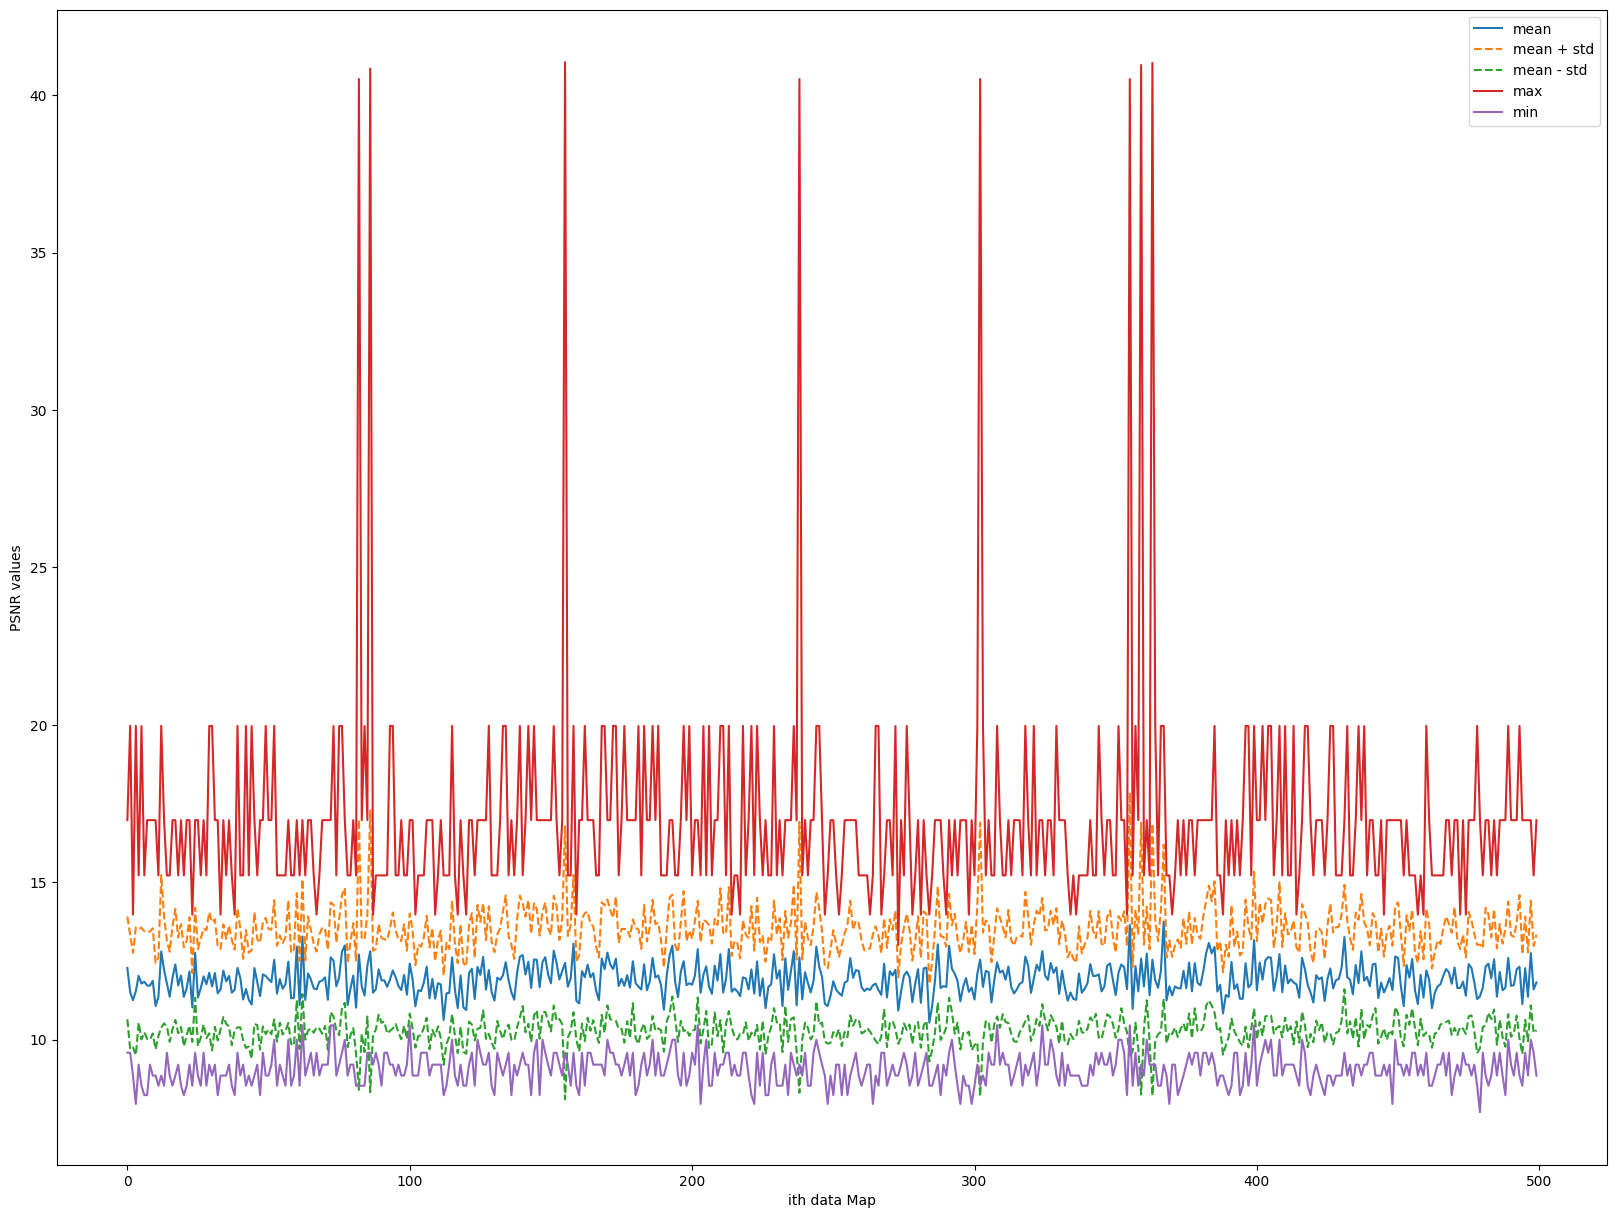

In [ ]:
psnr_values = read_csv_to_array(
    BASE_SAVE_FOLDER+f'output_{MAP_SIZE,NUM_DIPOLE_SAMPLES,NUM_DIPOLES_PER_SAMPLE,TYPE}.csv')
mean_psnr = jnp.mean(psnr_values, axis=1).T
std_psnr = jnp.std(psnr_values, axis=1).T
max_psnr = jnp.max(psnr_values, axis=1).T
min_psnr = jnp.min(psnr_values, axis=1).T

plt.figure(figsize=(20, 15))
plt.plot(mean_psnr, label='mean')
plt.plot(mean_psnr + std_psnr, label='mean + std', linestyle='--')
plt.plot(mean_psnr - std_psnr, label='mean - std', linestyle='--')
plt.plot(max_psnr, label='max')
plt.plot(min_psnr, label='min')
plt.xlabel('ith data Map')
plt.ylabel('PSNR values')
plt.legend()
plt.savefig(BASE_SAVE_FOLDER +
            f'output_{MAP_SIZE,NUM_DIPOLE_SAMPLES,NUM_DIPOLES_PER_SAMPLE,TYPE}.png')
plt.show()

# Using the Low rank Approximation

In [ ]:
# @jax.jit
# def singular_decompose(A):
#     _,sigma,_ = jnp.linalg.svd(A)
#     return sigma

# @jax.jit
# def PCA(A):
#     U,sigma,V = jnp.linalg.svd(A)
#     explained_variances = (sigma ** 2) / (len(sigma) - 1)
#     cumulative_explained_variances = jnp.cumsum(explained_variances) / jnp.sum(explained_variances)
#     num_components = jax.lax.while_loop(lambda x:cumulative_explained_variances[x]<1,lambda x:x+1,0)
#     pca_result = jnp.zeros((len(U),len(V)))
#     pca_result = jax.lax.fori_loop(0,num_components,lambda i,val: jnp.outer(U.T[i],V[i])+val,pca_result)
#     return pca_result,num_components

# A_subset = [temp_A_vec[int((i/9)*len(temp_A_vec))] for i in range(9)]
# for A_ in A_subset:
#     values,n = PCA(A_)
#     print(np.max(values),np.min(values),n)
# #     plt.plot(singular_decompose(A_))
# # plt.show()


# # temp_A_vec.shape

1.0000004 -0.24601506 87
1.0000001 -0.70710677 95
1.0 -1.3373781e-07 84
1.0000001 -1.1920929e-07 84
1.0000001 -0.40631753 84
1.0000001 -6.8825514e-08 84
1.0000001 -1.12288205e-07 86
1.0000001 -8.4293696e-08 85
1.0000001 -8.4293696e-08 85


In [13]:
@jax.jit
def PCA(A):
    U,sigma,V = jnp.linalg.svd(A)
    explained_variances = (sigma ** 2) / (len(sigma) - 1)
    cumulative_explained_variances = jnp.cumsum(explained_variances) / jnp.sum(explained_variances)
    num_components = jax.lax.while_loop(lambda x:cumulative_explained_variances[x]<=0.998,lambda x:x+1,0)
    pca_result = jnp.zeros((len(U),len(V)))
    pca_result = jax.lax.fori_loop(0,num_components,lambda i,val: jnp.outer(U.T[i],V[i])+val,pca_result)
    return pca_result

@jax.jit
def  solver_with_PCA(A,B):
    A = PCA(A)
    term1 = jnp.linalg.inv(jnp.dot(A.T, A))
    term2 = jnp.dot(A.T, B)
    X = jnp.dot(term1, term2)
    return X

low_resolved = []
for A,B in tqdm.tqdm(zip(temp_A_vec,temp_B_vec)):
    low_resolved.append(solver_with_PCA(A,B).reshape(MAP_SIZE))
    
low_resolved = jnp.array(low_resolved).reshape(NUM_MAP_SAMPLES,NUM_DIPOLE_SAMPLES,*MAP_SIZE)
print(low_resolved.shape) 

25000it [03:19, 125.13it/s]


(500, 50, 10, 10)


# Visualizing Results

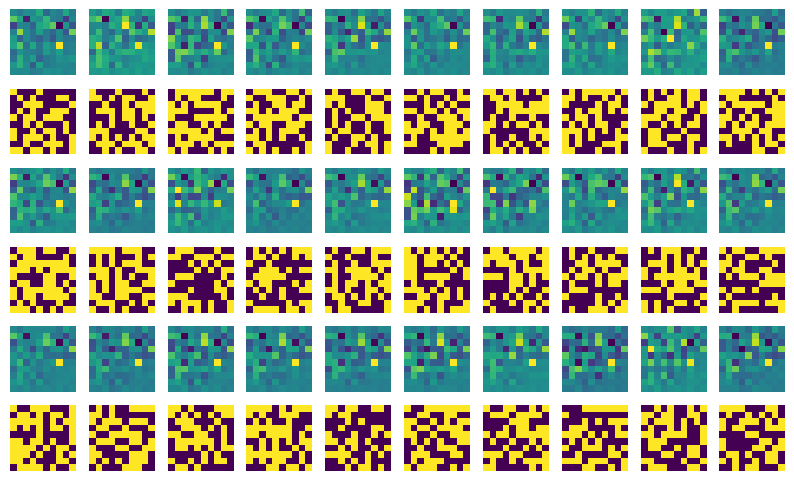

In [14]:
# Generate 9 random 2D images (example data)
low_reformed = low_resolved[:,0,:,:]
original = maps
M,N = 3,10
low_reformed_subset = np.array([low_reformed[i] for i in range(M*N)])
original_subset = np.array([original[i] for i in range(M*N)])


fig, axs = plt.subplots(2*M, N, figsize=(N, 2*M))

# Loop through the images and plot them in the grid
for i in range(M):
    for j in range(N):
        axs[2*i, j].imshow(original[i * N + j])  # Assuming grayscale images
        axs[2*i, j].axis('off')  # Turn off axis for clarity
        axs[2*i+1, j].imshow(low_reformed_subset[i * N + j],cmap = 'virdis')  # Assuming grayscale images
        axs[2*i+1, j].axis('off')  # Turn off axis for clarity
plt.savefig(BASE_SAVE_FOLDER +
            f'SAMPLES_results_{MAP_SIZE,NUM_DIPOLE_SAMPLES,NUM_DIPOLES_PER_SAMPLE}.png')
plt.show()  # Display the grid of images

# Again with low rank approximation

In [15]:
@jax.jit
def psnr(img1, img2):
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions")
    mse = jnp.mean((img1 - img2) ** 2)
    dynamic_range = jnp.max(img1) - jnp.min(img1)
    psnr_value = 20 * jnp.log10(dynamic_range) - 10 * jnp.log10(mse)
    return psnr_value


low_psnr_values = []
for i in tqdm.tqdm(range(NUM_MAP_SAMPLES)):
    temp_array = []
    for j in range(NUM_DIPOLE_SAMPLES):
        temp_array.append(psnr(maps[i],low_resolved[i][j]))
    low_psnr_values.append(temp_array)
    
low_psnr_values = np.array(low_psnr_values)
append_array_to_csv(BASE_SAVE_FOLDER+f'output_{MAP_SIZE,NUM_DIPOLE_SAMPLES,NUM_DIPOLES_PER_SAMPLE,TYPE}_low.csv',low_psnr_values)

100%|██████████| 500/500 [01:53<00:00,  4.42it/s]


Array appended to CSV successfully.


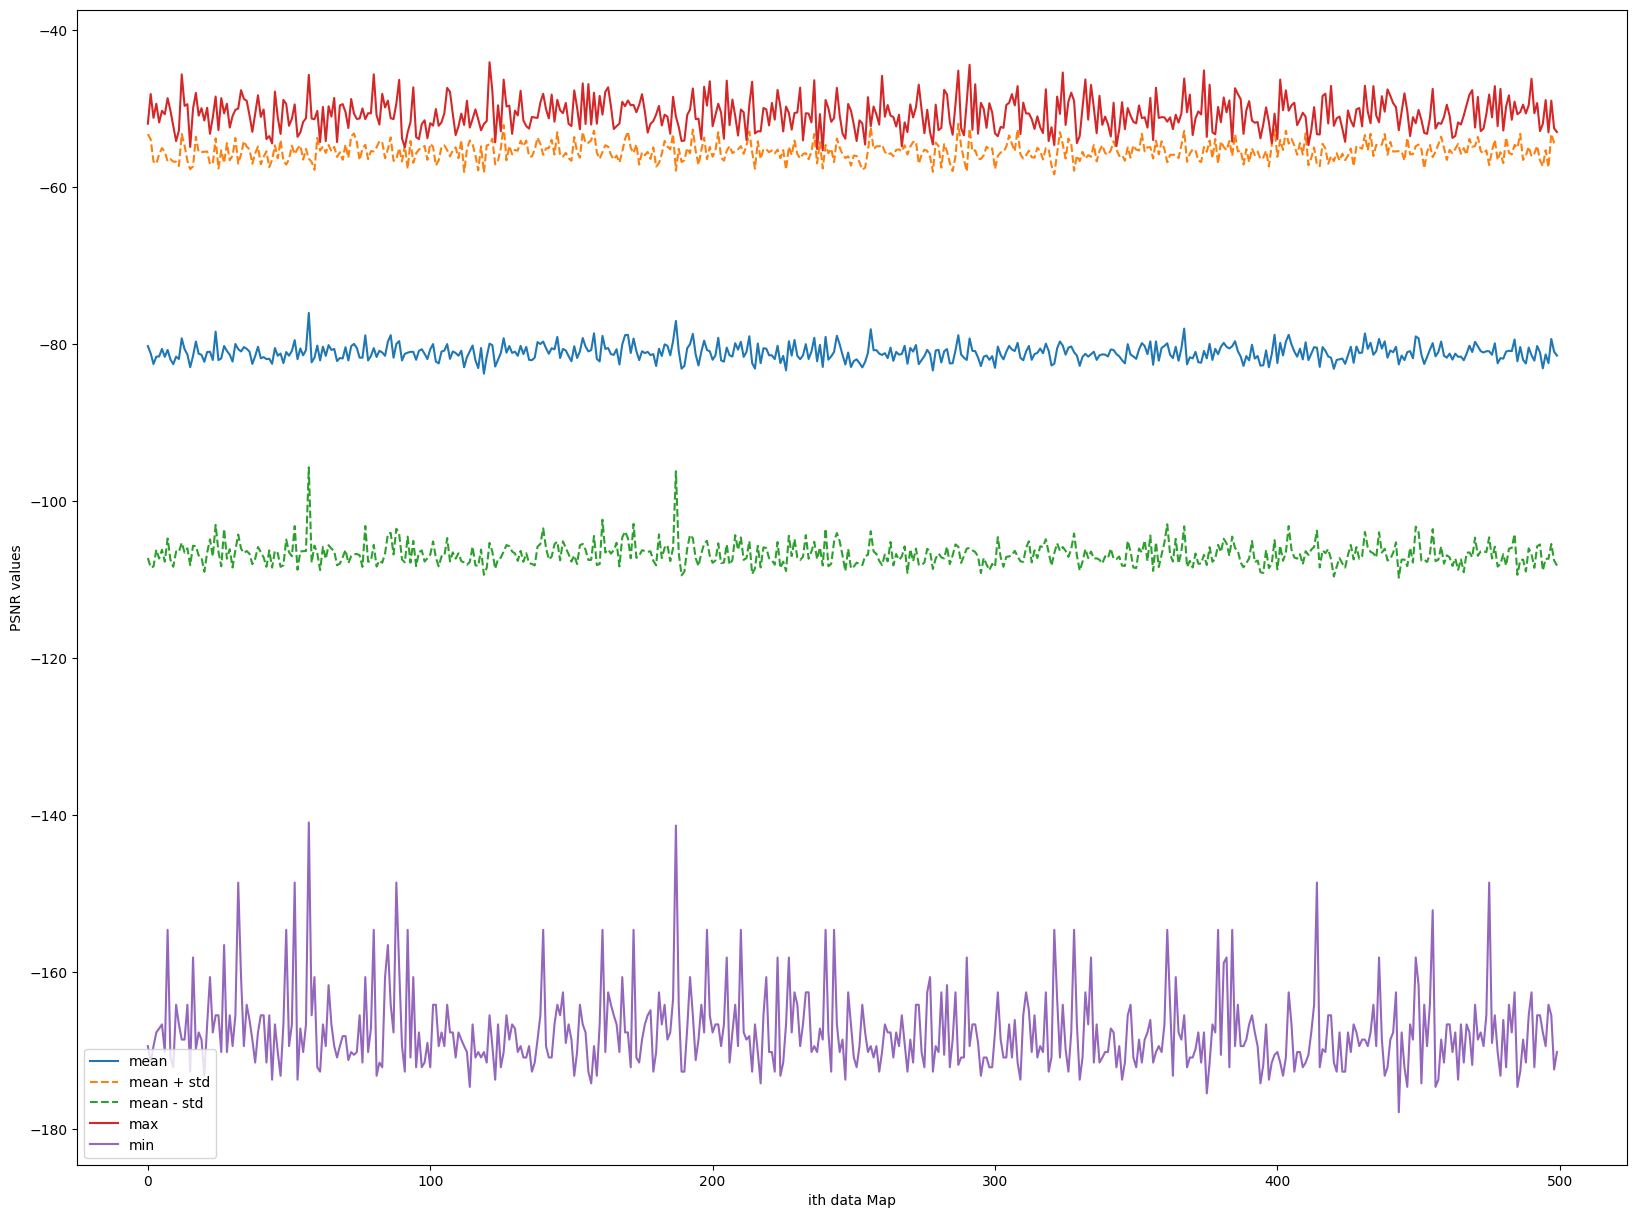

In [16]:
low_psnr_values = read_csv_to_array(BASE_SAVE_FOLDER+f'output_{MAP_SIZE,NUM_DIPOLE_SAMPLES,NUM_DIPOLES_PER_SAMPLE,TYPE}_low.csv')
mean_psnr = jnp.mean(low_psnr_values, axis=1).T
std_psnr = jnp.std(low_psnr_values, axis=1).T
max_psnr = jnp.max(low_psnr_values, axis=1).T
min_psnr = jnp.min(low_psnr_values, axis=1).T

plt.figure(figsize=(20, 15))
plt.plot(mean_psnr, label='mean')
plt.plot(mean_psnr + std_psnr, label='mean + std',linestyle='--')
plt.plot(mean_psnr - std_psnr, label='mean - std',linestyle='--')
plt.plot(max_psnr, label='max')
plt.plot(min_psnr, label='min')
plt.xlabel('ith data Map')
plt.ylabel('PSNR values')
plt.legend()
plt.savefig(BASE_SAVE_FOLDER +
            f'output_{MAP_SIZE,NUM_DIPOLE_SAMPLES,NUM_DIPOLES_PER_SAMPLE,TYPE}_low.png')
plt.show()